# VLSI - MIP Part
Di Tuccio Gianluca, Orsini Lorenzo

In [2]:
from tqdm import tqdm
from z3 import *
from numpy import random
import os
import pandas as pd

import gurobipy as gp
from gurobipy import GRB
import os


'''
SET HERE THE PATH OF THE MAIN FOLDER (i.e VLSI folder)
            |
            |
            V
'''
os.chdir('/Users/gianlucadituccio/Documents/VLSI')
from utils.utils import *

## MIP without Rotation

In [ ]:
def MIP(parameters, timeout=300):
    try:
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles]
        area_min = sum(x_components[i] * y_components[i] for i in range(n))
        h_min = area_min / w
        h_max = sum(y_components)
        M = h_max
        
        # declaration of the model
        model = gp.Model('MIP')
        model.params.OutputFlag = 0 # hide inter-outputs
        model.setParam('TimeLimit', timeout)
        
        # declaration of the variables for GUROBY
        x_positions = model.addVars(n, ub = w, vtype = GRB.INTEGER, name = 'x_positions')
        y_positions = model.addVars(n, ub = h_max, vtype = GRB.INTEGER, name = 'y_positions')
        OR_overlap = model.addVars(n, n, 4, vtype = GRB.BINARY, name = 'OR_overlap') # used for the OR of the overlap constraints
        height = model.addVar(vtype = GRB.INTEGER, name = 'height')
        
        # position + component <= plate width
        model.addConstrs(((x_positions[i] + x_components[i] <= w) for i in range(n)), 'width_constraint')
        model.addConstrs(((y_positions[i] + y_components[i] <= height) for i in range(n)), 'height_constraint')

        # non overlap constraints
        model.addConstrs(((x_positions[i] + x_components[i] <= x_positions[j] + M*OR_overlap[i,j,0]) for i in range(n) for j in range(i+1,n)), "or1")
        model.addConstrs(((y_positions[i] + y_components[i] <= y_positions[j] + M*OR_overlap[i,j,1]) for i in range(n) for j in range(i+1,n)), "or2")
        model.addConstrs(((x_positions[j] + x_components[j] <= x_positions[i] + M*OR_overlap[i,j,2]) for i in range(n) for j in range(i+1,n)), "or3")
        model.addConstrs(((y_positions[j] + y_components[j] <= y_positions[i] + M*OR_overlap[i,j,3]) for i in range(n) for j in range(i+1,n)), "or4")
        model.addConstrs((gp.quicksum(OR_overlap[i,j,k] for k in range(4)) <= 3 for i in range(n) for j in range(n)), 'no_overlap_constraint') 

        # higher block in (0,0)
        model.addConstr(x_positions[0] == 0, 'x_0_0')
        model.addConstr(y_positions[0] == 0, 'y_0_0')
        
        # positions >= 0
        model.addConstrs((x_positions[i] >= 0 for i in range(n)), 'x_positive_coordinates_constraint')
        model.addConstrs((y_positions[i] >= 0 for i in range(n)), 'y_positive_coordinates_constraint')
        
        # height constraints
        model.addConstr(height >= h_min, 'height_min_constraint')
        model.addConstr(height <= h_max, 'height_max_constraint')
        
        # area constraints
        model.addConstr(height * w >= area_min, 'area_min_constraint')
        model.addConstr(height * w <= h_max * w, 'area_min_constraint')
        
        # objective function
        model.setObjective(height, GRB.MINIMIZE)
        
        t1 = time.time()
        model.optimize()
        t2 = time.time() - t1
        
        x_positions = []
        y_positions = []

        for i in range(n):
            x_positions.append(int(model.getVarByName(f'x_positions[{i}]').X))
            y_positions.append(int(model.getVarByName(f'y_positions[{i}]').X))
        
        # re-take the original order of the rectangles
        positions = [(x, y, i, z, k) for x, y, i, z, k in zip(x_positions, y_positions, x_components, y_components, original_indices)]
        x_positions, y_positions, x_components, y_components, _ = zip(*sorted(positions, key=lambda x: x[4]))
            
        height_found = int(model.ObjVal)
        return {'x_components':x_components,
                'y_components':y_components,
                'x_positions':x_positions,
                'y_positions':y_positions,
                'h':height_found,
                'time':t2,
                'W':w}
        
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    t0 = time.time()
    
    result = MIP(parameters=file, timeout=300)
    t1 = time.time()
    time_computation = t1-t0
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='MIP/images', 
                     name='fig-'+str(i))
        WriteInstance(result,
                     path='MIP/out',
                     name='out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

## MIP with Rotation
Here, we simply add two new array for storing the components when the rotation is enabled.

In [ ]:
def MIP(parameters, timeout=300):
    try:
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()

        # sort rectangles by y component and find the min/max height
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles] 
        area_min = sum(x_components[i]*y_components[i] for i in range(n))
        h_min = area_min / w
        h_max = sum(y_components)
        M = h_max
        
        # declaration of the model
        model = gp.Model('MIP')
        model.params.OutputFlag = 0 # hide inter-outputs
        model.setParam('TimeLimit', timeout)
        
        # declaration of the variables for GUROBY
        x_positions = model.addVars(n, ub=w, vtype=GRB.INTEGER, name='x_positions')
        y_positions = model.addVars(n, ub=h_max, vtype=GRB.INTEGER, name='y_positions')
        OR_overlap = model.addVars(n, n, 4, vtype=GRB.BINARY, name='OR_overlap') # used for the OR of the overlap constraints
        x_components_rotated = model.addVars(n, vtype=GRB.INTEGER, name='x_components_rotated')
        y_components_rotated = model.addVars(n, vtype=GRB.INTEGER, name='y_components_rotated')
        rot = model.addVars(n, vtype=GRB.BINARY, name='rotation') # 0 --> no rotation, 1 --> rotation
        height = model.addVar(vtype=GRB.INTEGER, name='height')
        
        # position + component <= plate width
        model.addConstrs(((x_positions[i]+x_components_rotated[i] <= w) for i in range(n)), 'width_constraint')
        model.addConstrs(((y_positions[i]+y_components_rotated[i] <= height) for i in range(n)), 'height_constraint')

        # non overlap constraints
        model.addConstrs(((x_positions[i]+x_components_rotated[i] <= x_positions[j] + M*OR_overlap[i,j,0]) for i in range(n) for j in range(i+1,n)), "or1")
        model.addConstrs(((y_positions[i]+y_components_rotated[i] <= y_positions[j] + M*OR_overlap[i,j,1]) for i in range(n) for j in range(i+1,n)), "or2")
        model.addConstrs(((x_positions[j]+x_components_rotated[j] <= x_positions[i] + M*OR_overlap[i,j,2]) for i in range(n) for j in range(i+1,n)), "or3")
        model.addConstrs(((y_positions[j]+y_components_rotated[j] <= y_positions[i] + M*OR_overlap[i,j,3]) for i in range(n) for j in range(i+1,n)), "or4")
        model.addConstrs((gp.quicksum(OR_overlap[i,j,k] for k in range(4))<=3 for i in range(n) for j in range(n)), 'no_overlap_constraint') 

        # higher block in (0,0)
        model.addConstr(x_positions[0] == 0, 'x_0_0')
        model.addConstr(y_positions[0] == 0, 'y_0_0')
        
        # if we want to rotate the rectangle, the x_component must be lower than the height of the plate
        model.addConstrs(((x_components_rotated[i] <= height) for i in range(n)))
        model.addConstrs(((y_components_rotated[i] <= w) for i in range(n)))
        model.addConstrs(((rot[i] == 0) for i in range(n) if x_components[i] == y_components[i]))
        
        # positions >= 0
        model.addConstrs((x_positions[i] >= 0 for i in range(n)), 'x_positive_coordinates_constraint')
        model.addConstrs((y_positions[i] >= 0 for i in range(n)), 'y_positive_coordinates_constraint')
        
        # height constraints
        model.addConstr(height >= h_min, 'height_min_constraint')
        model.addConstr(height <= h_max, 'height_max_constraint')
        
        # rotation constraints (0 --> no rotation, 1 --> rotation)
        # if the rotation is set to 0, then assign y_components to y_components_rotated, otherwise assign the opposite components
        model.addConstrs(((y_components_rotated[i] == rot[i]*x_components[i] + (1-rot[i])*y_components[i]) for i in range(n)), 'x_rotation')
        model.addConstrs(((x_components_rotated[i] == rot[i]*y_components[i] + (1-rot[i])*x_components[i]) for i in range(n)), 'y_rotation')
        
        # area constraints
        model.addConstr(height * w >= area_min, 'area_min_constraint')
        model.addConstr(height * w <= h_max * w, 'area_min_constraint')
        
        # objective function
        model.setObjective(height, GRB.MINIMIZE)
        
        t1 = time.time()
        model.optimize()
        t2 = time.time() - t1
        if t2>timeout:
            return {}
        
        x_positions = []
        y_positions = []
        rota = []

        for i in range(n):
            x_positions.append(int(model.getVarByName(f'x_positions[{i}]').X))
            y_positions.append(int(model.getVarByName(f'y_positions[{i}]').X))
            rota.append(int(model.getVarByName(f'rotation[{i}]').X))
        
        rota = [False if rota[index]==0 else True for index in range(n)]
        tmp1 = [y_components[i] if rota[i] else x_components[i] for i in range(len(x_components))]
        y_components = [x_components[i] if rota[i] else y_components[i] for i in range(len(y_components))]
        x_components = tmp1
        
        # re-take the original order of the rectangles
        positions = [(x, y, i, z, k, q) for x, y, i, z, k, q in zip(x_positions, y_positions, x_components, y_components, rota, original_indices)]
        x_positions, y_positions, x_components, y_components, rota, _ = zip(*sorted(positions, key=lambda x: x[5]))
        
        
        height_found = int(model.ObjVal)
        return {'x_components':x_components,
                'y_components':y_components,
                'x_positions':x_positions,
                'y_positions':y_positions,
                'h':height_found,
                'time':t2,
                'W':w}
        
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')  
    result = MIP(parameters=file, timeout=300)
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='MIP/images', 
                     name='rotation_fig-'+str(i))
        WriteInstance(result,
                     path='MIP/out',
                     name='rotation_out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

## Results

In [3]:
results = pd.read_csv('utils/datasets/MIP.csv')
Statistics({'No Rotation':results['time'],
            'Rotation':results['time_rotation']}, 
           {'h_min':results['h_min'],  
            'Rotation':results['h_rotation'],
            'No Rotation':results['h']},
            timeout=300)

TIMEOUT is seen as 300s.

+------------------+-------------+----------+
|                  | No Rotation | Rotation |
+------------------+-------------+----------+
|  Total Time [s]  |    2815.366 | 4109.279 |
|     Max [s]      |       300.0 |    300.0 |
|     Min [s]      |       0.007 |    0.001 |
|     Mean [s]     |      70.384 |  102.732 |
|     Std [s]      |     110.566 |  134.659 |
| Instances Solved |       34/40 |    28/40 |
|    Optimal H     |       34/40 |    28/40 |
+------------------+-------------+----------+


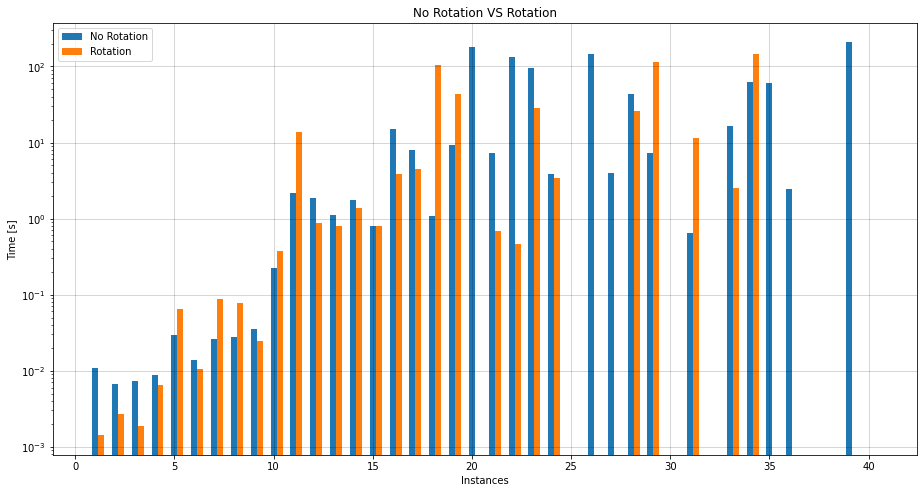

In [4]:
PlotStats({'No Rotation':results['time'],
            'Rotation':results['time_rotation']},
            x_axis=list(results['Instance']))